# **5. Transfer learning with ResNet-50**

So far, we have created a CNN from scratch and tried to improve it as much as possible so that we could get a high enough accuracy in both training and testing datasets. 

Our next step is trying to use the power of pre-trained networks and apply them to our problem, a technique most commonly known as transfer learning. In this series of notebooks (Notebooks 5.x and 6) we will apply transfer learning using popular neural network architectures.

# Introduction

## What is transfer learning?

When building a CNN to solve a classification problem, there are two common ways in which we can proceed:

1. Build a new model architecture from scratch.
2. Use the knowledge from a previously trained model and apply it to the current problem transfer.

Transfer learning involves applying the second methodology, in which we take a pre-trained neural network that has been trained on a large and diverse dataset and use its knowledge as a starting point for solving a new problem. 

There are several ways in which transfer learning can be applied:

1. Feature extraction: In this approach, the pre-trained model is used as a fixed feature extractor, and the extracted features are then used as input for training a classifier on the current problem. In this case, the weights of the pre-trained model are not updated during this training process (the model stays fully *frozen*), so it requires that the problem at hand is similar enough to the problem the pre-trained model was originally designed to solve.

2. Fine-tuning: In this a technique we use a pre-trained model and adjust it to perform a similar task to the original. There are two different approaches we can take:

+ Combining the pre-trained model with a new classifier. This involves freezing the convolutional base of the pre-trained model and training a new classifier on top of it. The pre-trained model acts as a feature extractor, and the new classifier is trained to make predictions specific to the new task. This is the approach followed in notebooks 5.1 and 5.2 (ResNet-50 and MobileNet)

+ Unfreezing the last few layers of the convolutional part to better adjust them to the new task, and retraining them and the classifier. This approach allows us to retain most of the network intact, keeping the general features in place while allowing the model to learn some new, more specific features from our dataset. Although training the model takes longer than using the classifier for feature extraction, it allows us to adapt the pre-trained model to our specific problem. This is the approach followed in the subsection 5.3 notebooks (VGG-16 & VGG-19)

Overall, fine-tuning is a powerful technique for transfer learning as it leverages the pre-trained model's general feature extraction capabilities and adapts them to a new task. It is particularly useful when we have limited data for the new task, as it reduces the risk of overfitting by leveraging the pre-trained features.

**Sources**

+ Brownlee, J. (2019) A gentle introduction to transfer learning for Deep learning, MachineLearningMastery.com. [Online]. Available at: https://machinelearningmastery.com/transfer-learning-for-deep-learning/ (Accessed: April 2, 2023). 
+ Mwiti, D. (2023) Transfer learning guide: A practical tutorial with examples for images and text in Keras, neptune.ai. [Online]. Available at: https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras (Accessed: April 2, 2023). 

## ResNet-50

The main innovation of the ResNet (Residual Network) architecture is the use of residual blocks, which allow for the construction of much deeper neural networks without degradation in performance.

Traditional deep neural networks suffer from the vanishing gradient problem, where the gradients propagated through the network during training become so small that they effectively "disappear" as they propagate back through earlier layers. This limits the ability to train very deep networks.

ResNet overcomes this problem by using residual blocks, which include skip connections that allow the input from earlier layers to be added directly to the output of later layers. By doing so, the gradient can be more easily propagated through the network, even in very deep architectures. This enables the construction of networks with hundreds of layers that can still be trained effectively.

**Source:** He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition. arXiv preprint arXiv:1512.03385. [Online]. Available at: https://arxiv.org/abs/1512.03385

First of all, let's load the required libraries in order to run the code:

In [1]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow.keras as keras
from tensorflow import debugging as tfdbg
from tensorflow import device
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50
from tensorflow.keras.applications import ResNet50

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves

2023-04-04 08:42:48.601059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-04 08:42:48.601144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-04 08:42:48.601153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Now let's see how our data is structured:

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [5]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Renaissance', 'Realism', 'Baroque', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Renaissance   4000         500   500
Realism       4000         500   500
Baroque       4000         500   500
Romanticism   4000         500   500


We'll also create the directory, if not created yet, where the models will be saved:

In [6]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

*Explain dropout and data augmentation, include reference to original paper*

# **5.1 ResNet-50 with frozen convolutional base (just training classifier)**

## 5.1.1. Model structure

Let's first create the model structure:

Firstly, let's define the values of some hyperparameters:

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (224, 224,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [8]:
conv_base = ResNet50( 
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=input_shape
)

# Create the model
model = models.Sequential()

# Add the convolutional base
model.add(conv_base)

# Add the classifier
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

# Freeze the convolutional base
model.layers[0].trainable = False

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [10]:
# optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0001)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

## 5.1.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step...

In [11]:
# Apply data augmentation to the training set
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1),
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
    )

# The data augmentation must not be used for the test set!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [12]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (128, 224, 224, 3)
Labels batch shape: (128, 4)


*We can appreciate that...*

## 5.1.3. Training

Let's train the model:

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to avoid *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training:

In [13]:
# Model name and path
model_path = os.path.join("models", "resnet50_frozen_model.h5")

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
 48/125 [==========>...................] - ETA: 4:31 - loss: 1.7207 - acc: 0.3534

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.5930 - acc: 0.3779
Epoch 1: val_loss improved from inf to 1.48917, saving model to models/resnet50_frozen_model.h5
125/125 [==============================] - 484s 4s/step - loss: 1.5930 - acc: 0.3779 - val_loss: 1.4892 - val_acc: 0.3070
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.3525 - acc: 0.4162
Epoch 2: val_loss improved from 1.48917 to 1.28481, saving model to models/resnet50_frozen_model.h5
125/125 [==============================] - 463s 4s/step - loss: 1.3525 - acc: 0.4162 - val_loss: 1.2848 - val_acc: 0.3578
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.2662 - acc: 0.4413
Epoch 3: val_loss did not improve from 1.28481
125/125 [==============================] - 463s 4s/step - loss: 1.2662 - acc: 0.4413 - val_loss: 1.4108 - val_acc: 0.2648
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 1.2123 - acc: 0.4636
Epoch 4: val_loss improved from 1.2848

Now let's load the best model found:

In [16]:
# load the saved model
saved_model = load_model(model_path)

## 5.1.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

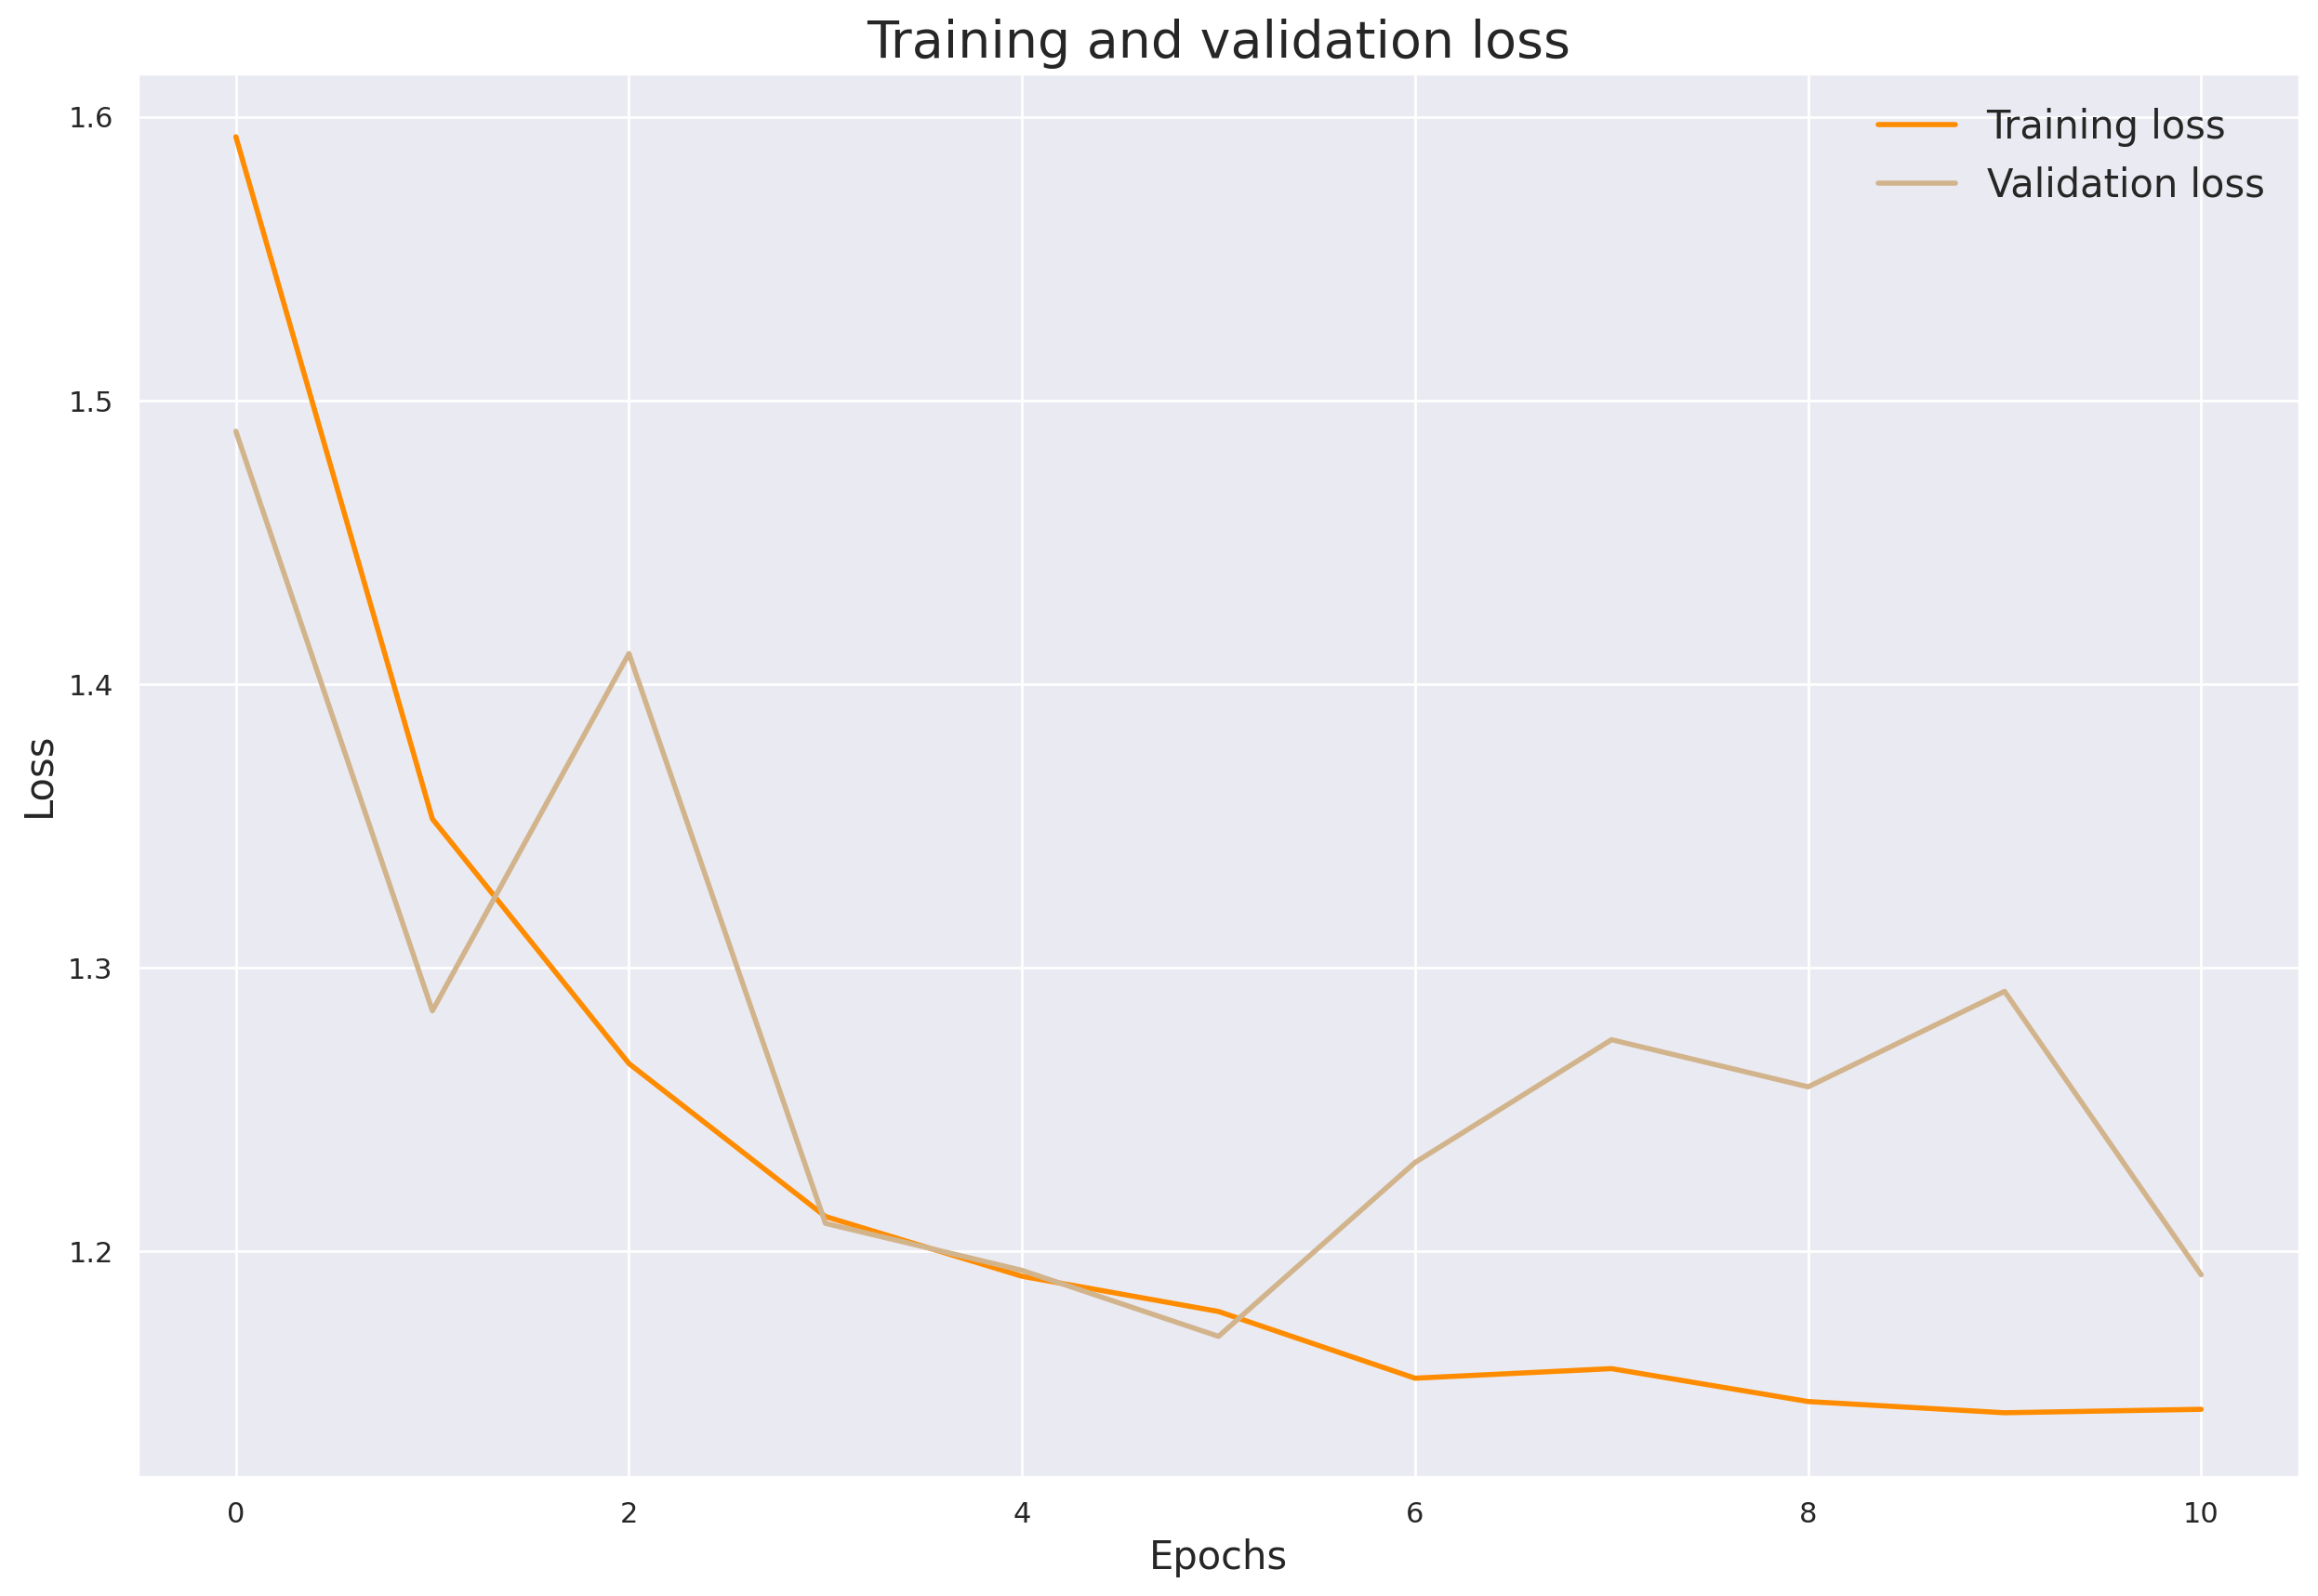

In [18]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkorange", "tan", "Loss")

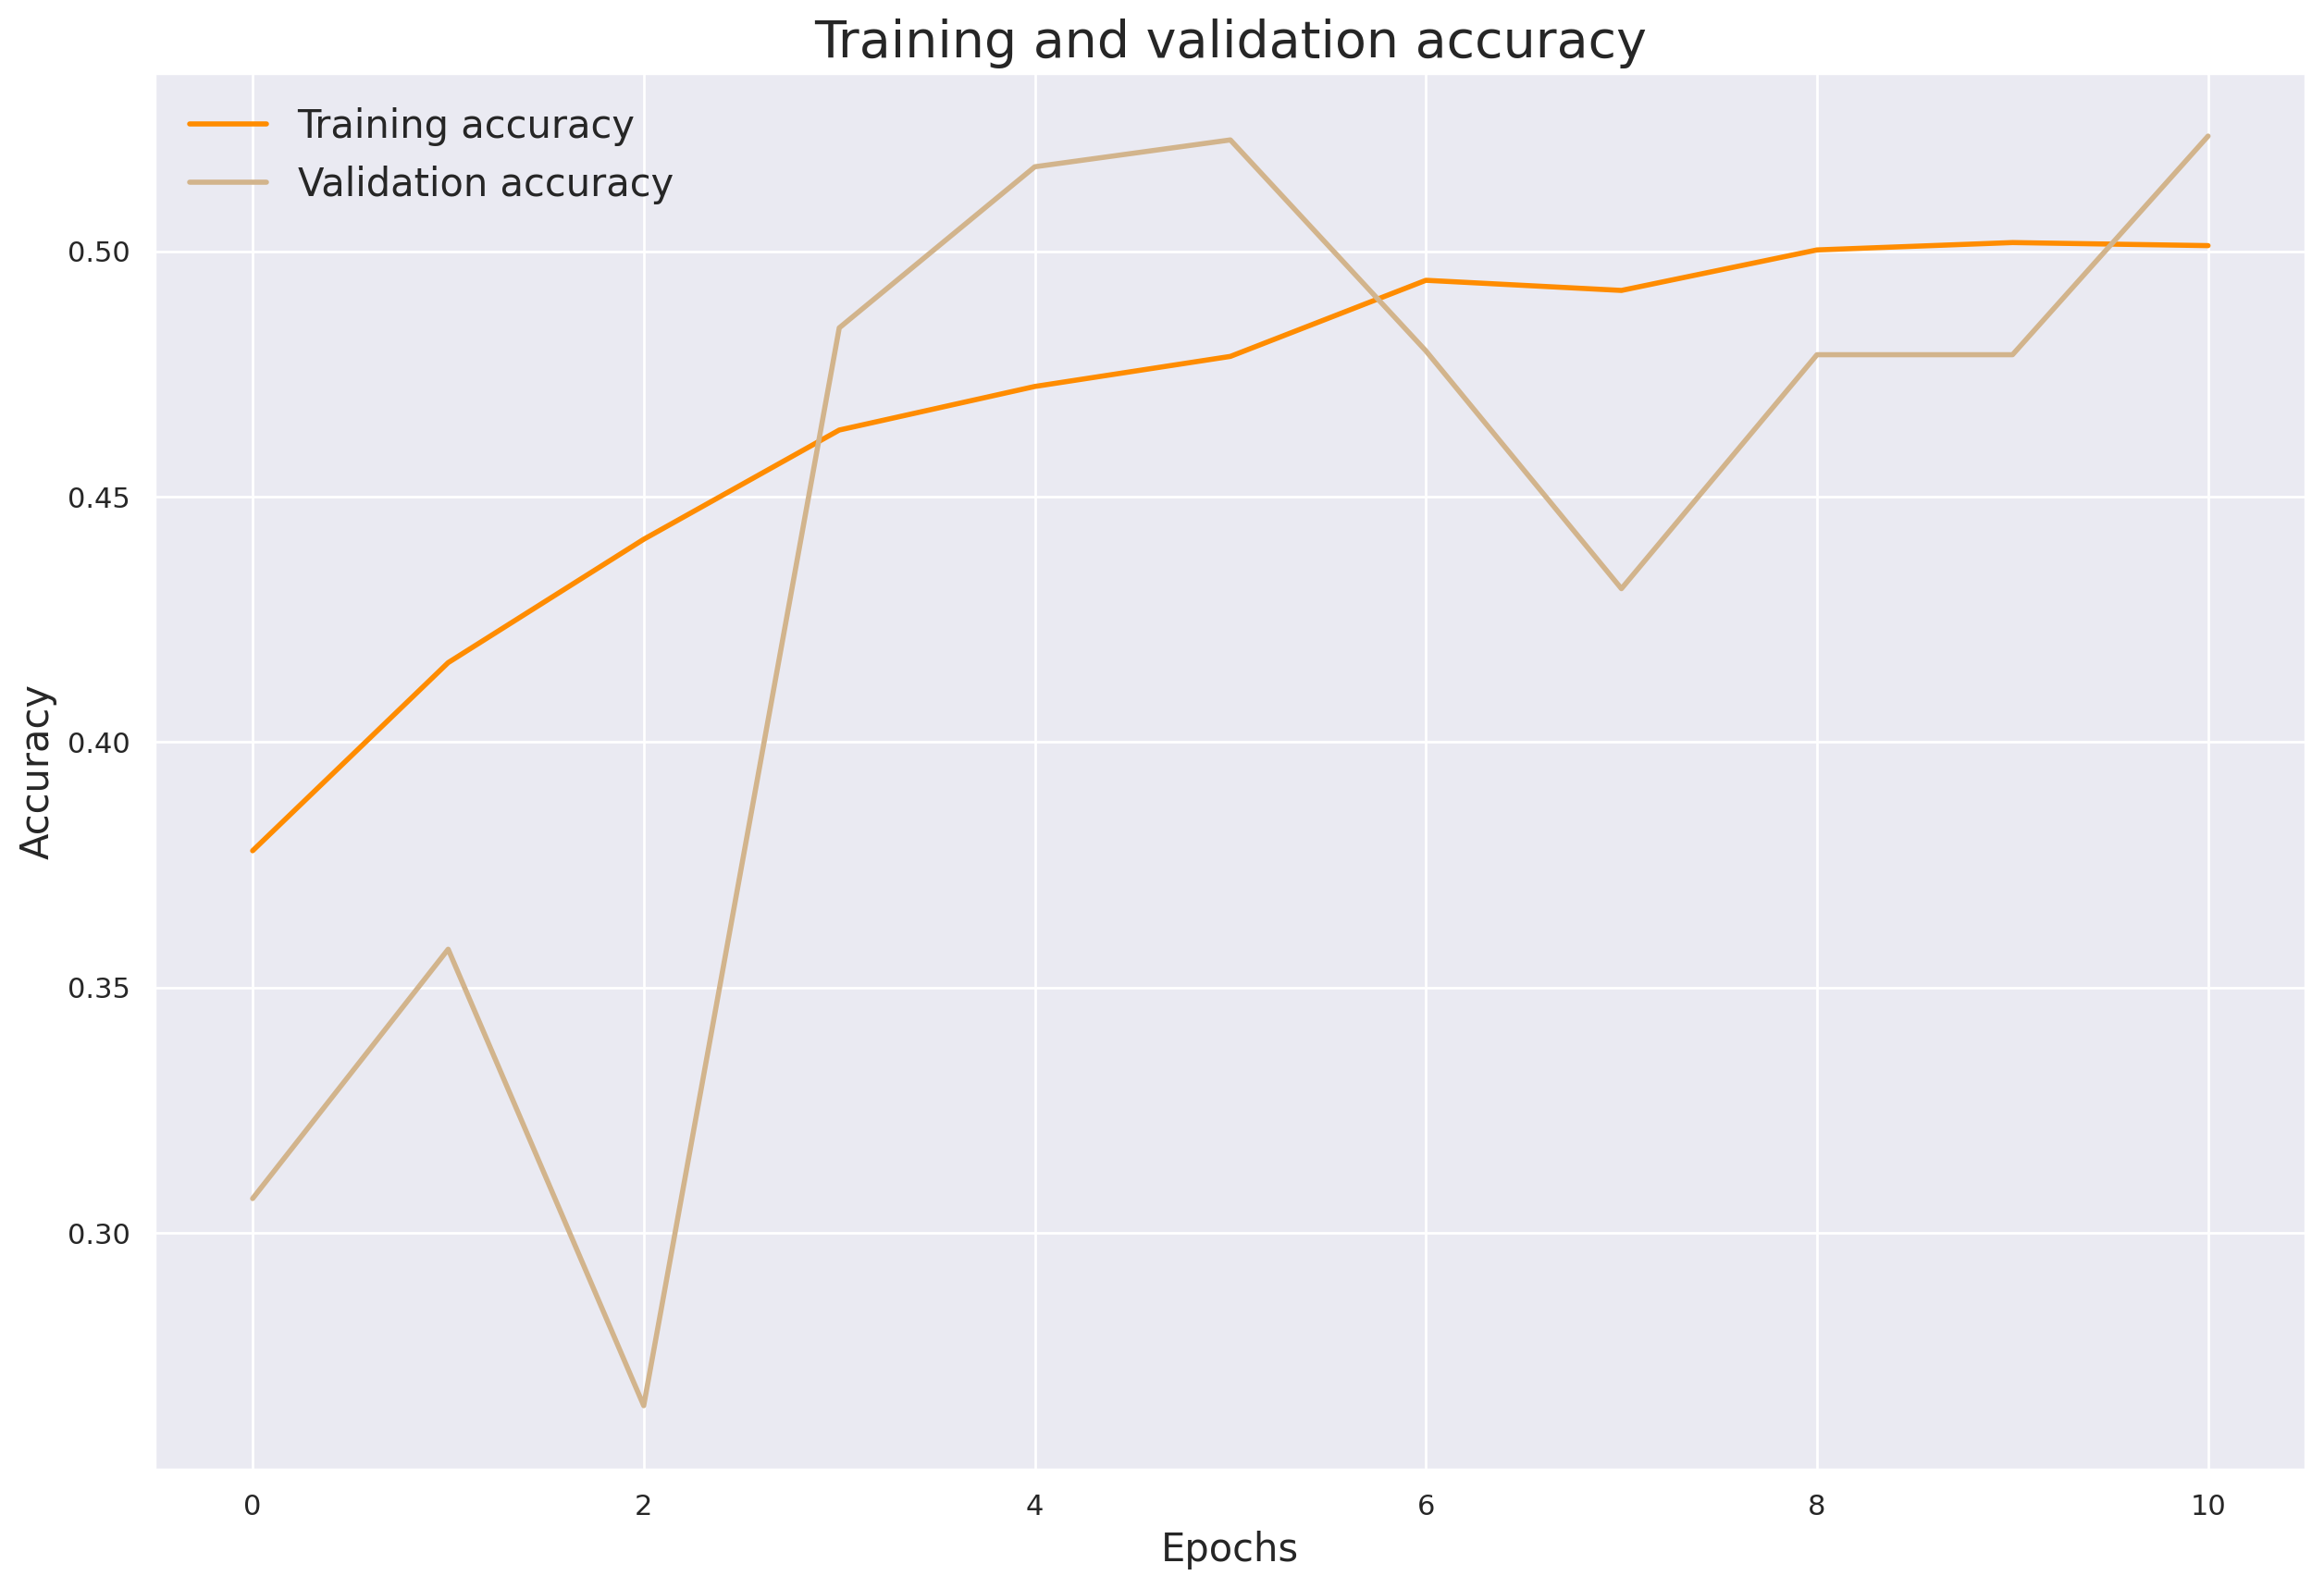

In [19]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkorange", "tan", "Accuracy")

In [20]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
)

Found 2000 images belonging to 4 classes.


In [21]:
model.evaluate(test_generator)

50/50 [==============================] - 36s 711ms/step - loss: 1.1712 - acc: 0.5000


[1.1711816787719727, 0.5]

In [22]:
saved_model.evaluate(test_generator)

50/50 [==============================] - 33s 635ms/step - loss: 1.1800 - acc: 0.4795


[1.1799978017807007, 0.4794999957084656]

*Comments about how those metrics have evolved...*

# **5.2 ResNet-50 training classifier and last convolutional layer**

## 5.2.1. Model structure

Let's first create the model structure:

Firstly, let's define the values of some hyperparameters:

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (224, 224,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [8]:
conv_base = ResNet50( 
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=input_shape
    )

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
# Freeze the convolutional base unless the last layer
conv_base.trainable = True

# Unfreeze the last layer
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Create the model
model = models.Sequential()

# Add the convolutional base
model.add(conv_base)

# Add the classifier
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

## 5.2.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step...

In [12]:
# Apply data augmentation to the training set
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1),
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

# The data augmentation must not be used for the test set!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [13]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (128, 224, 224, 3)
Labels batch shape: (128, 4)


*We can appreciate that...*

## 5.2.3. Training

Let's train the model:

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to avoid *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training:

In [14]:
# Model name and path
model_path = os.path.join("models", "resnet50_unfrozen_model.h5")

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
  8/125 [>.............................] - ETA: 6:32 - loss: 2.0369 - acc: 0.2959

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.5614 - acc: 0.3891
Epoch 1: val_loss improved from inf to 1.94877, saving model to models/resnet50_unfrozen_model.h5
125/125 [==============================] - 502s 4s/step - loss: 1.5614 - acc: 0.3891 - val_loss: 1.9488 - val_acc: 0.2211
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.3269 - acc: 0.4304
Epoch 2: val_loss improved from 1.94877 to 1.83518, saving model to models/resnet50_unfrozen_model.h5
125/125 [==============================] - 473s 4s/step - loss: 1.3269 - acc: 0.4304 - val_loss: 1.8352 - val_acc: 0.2344
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.2234 - acc: 0.4692
Epoch 3: val_loss improved from 1.83518 to 1.28706, saving model to models/resnet50_unfrozen_model.h5
125/125 [==============================] - 469s 4s/step - loss: 1.2234 - acc: 0.4692 - val_loss: 1.2871 - val_acc: 0.4578
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 

Now let's load the best model found:

In [17]:
# load the saved model
saved_model = load_model(model_path)

## 5.2.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

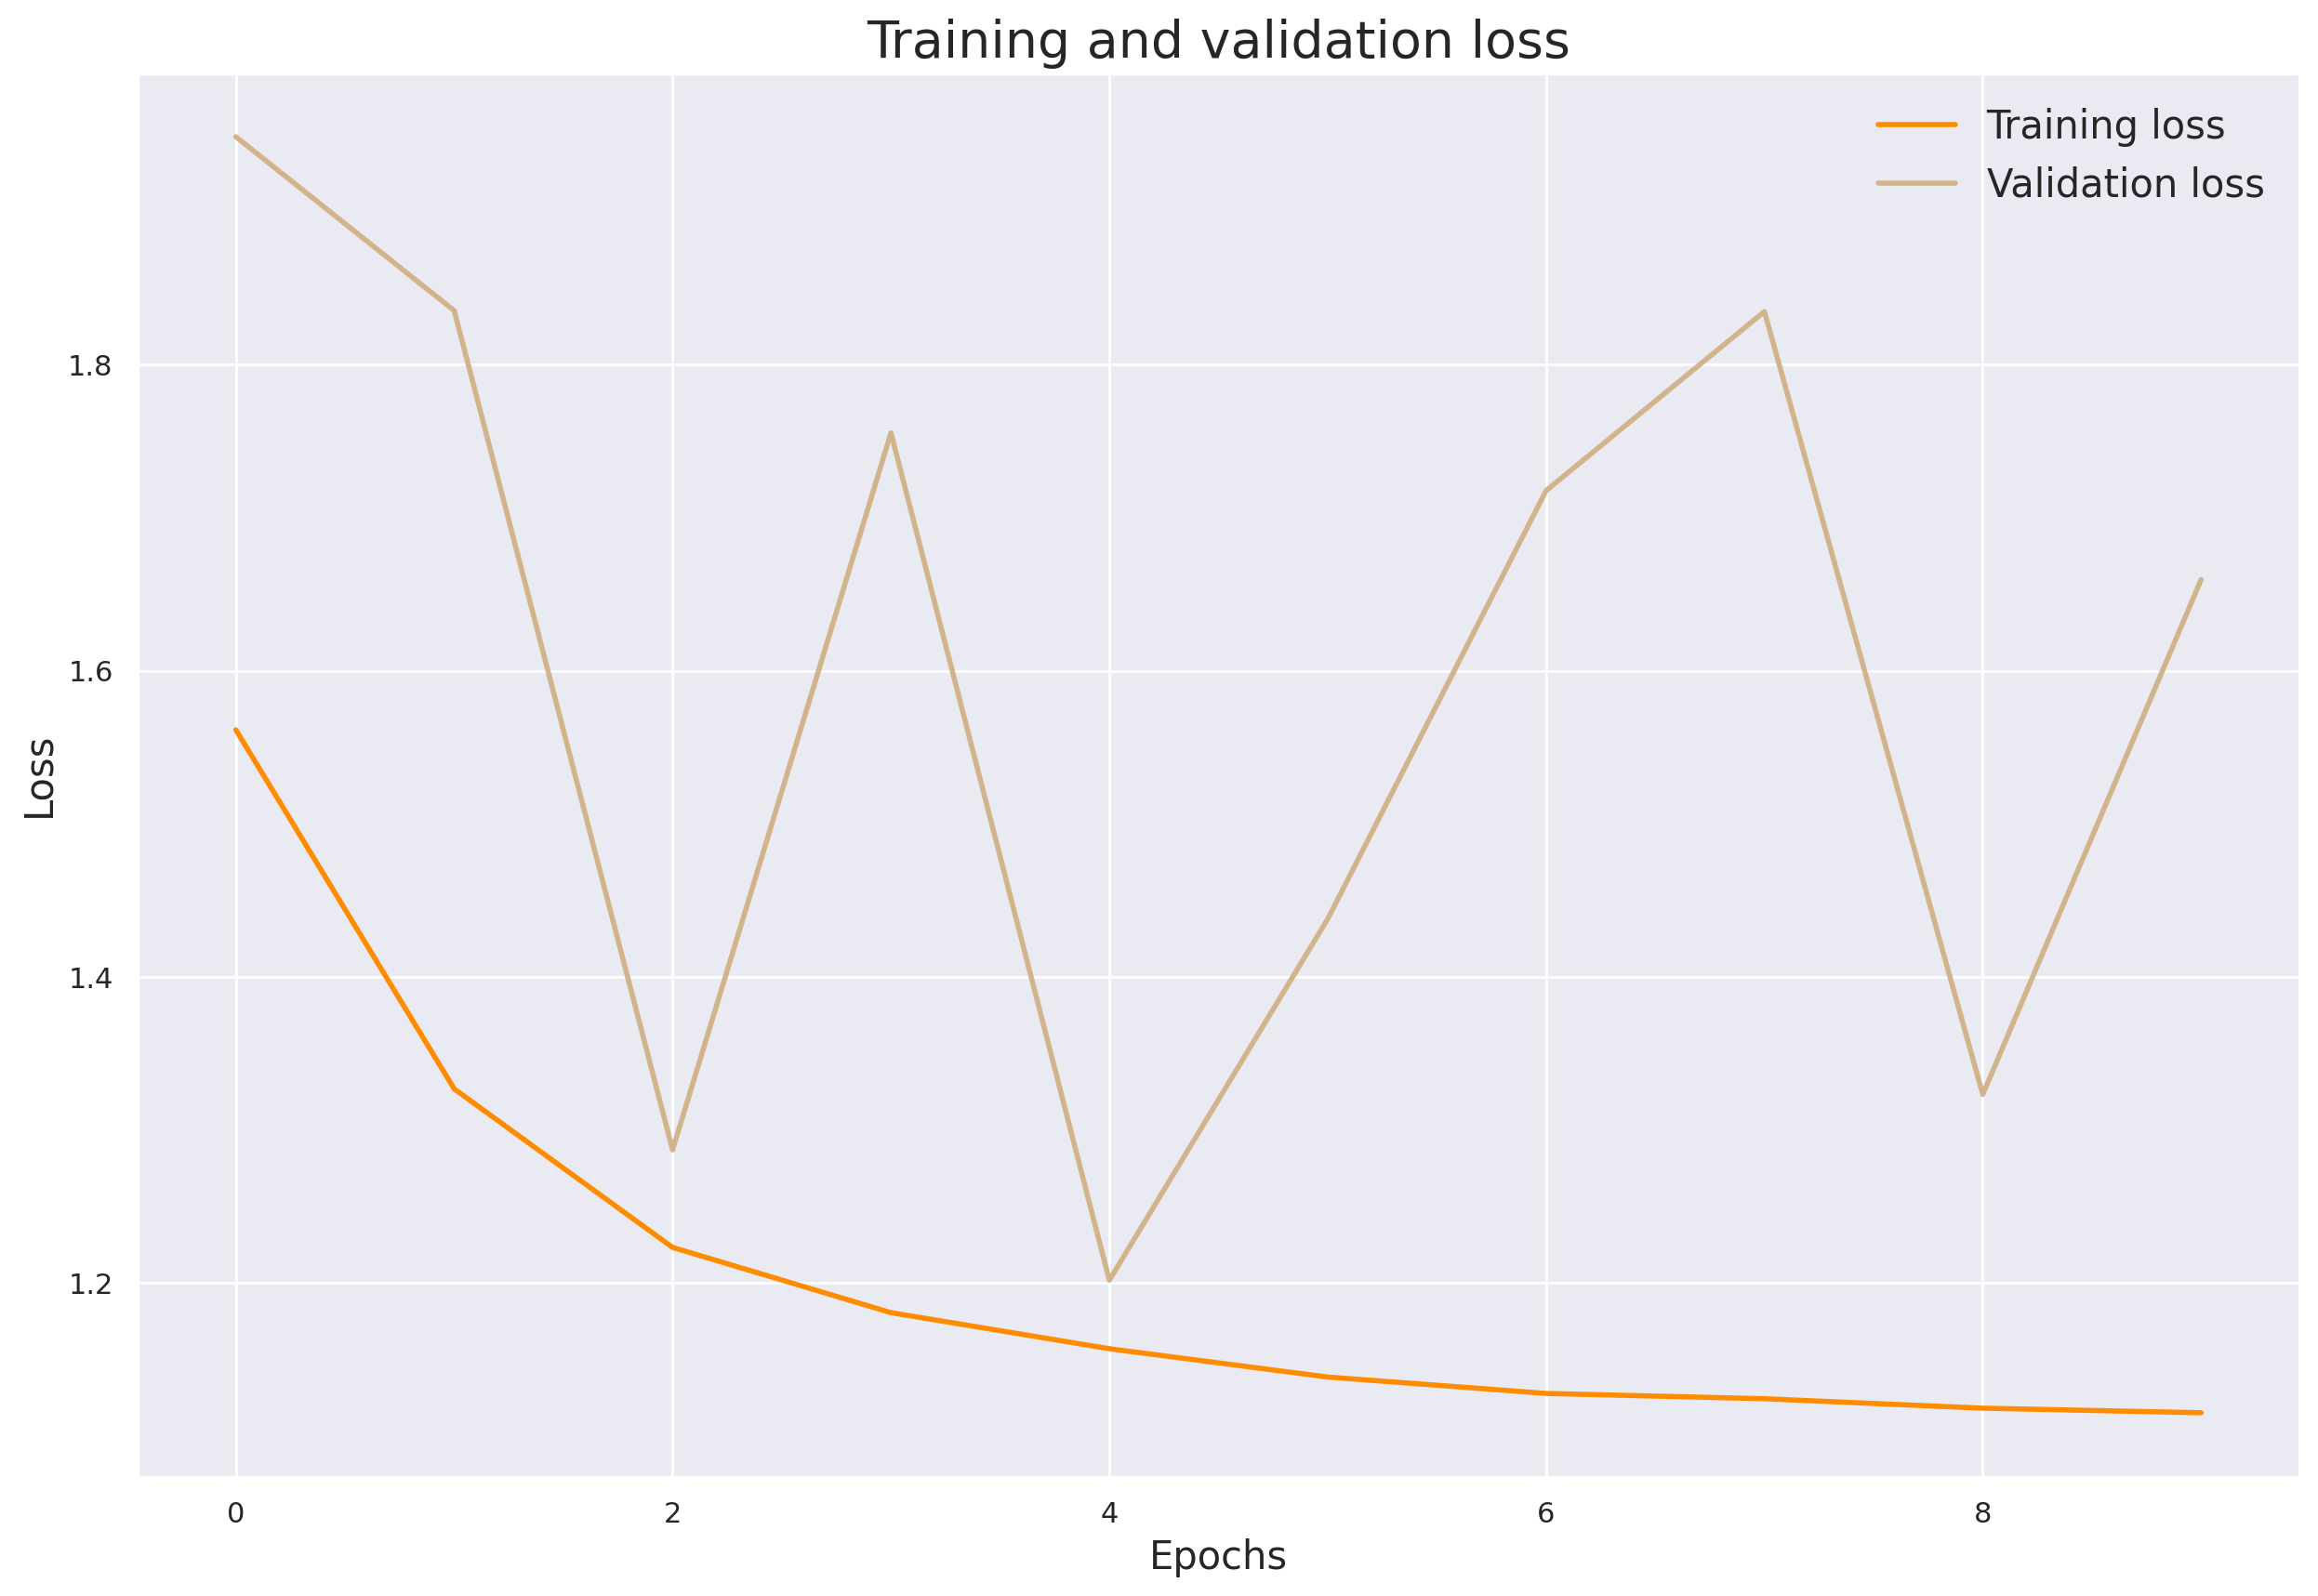

In [19]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkorange", "tan", "Loss")

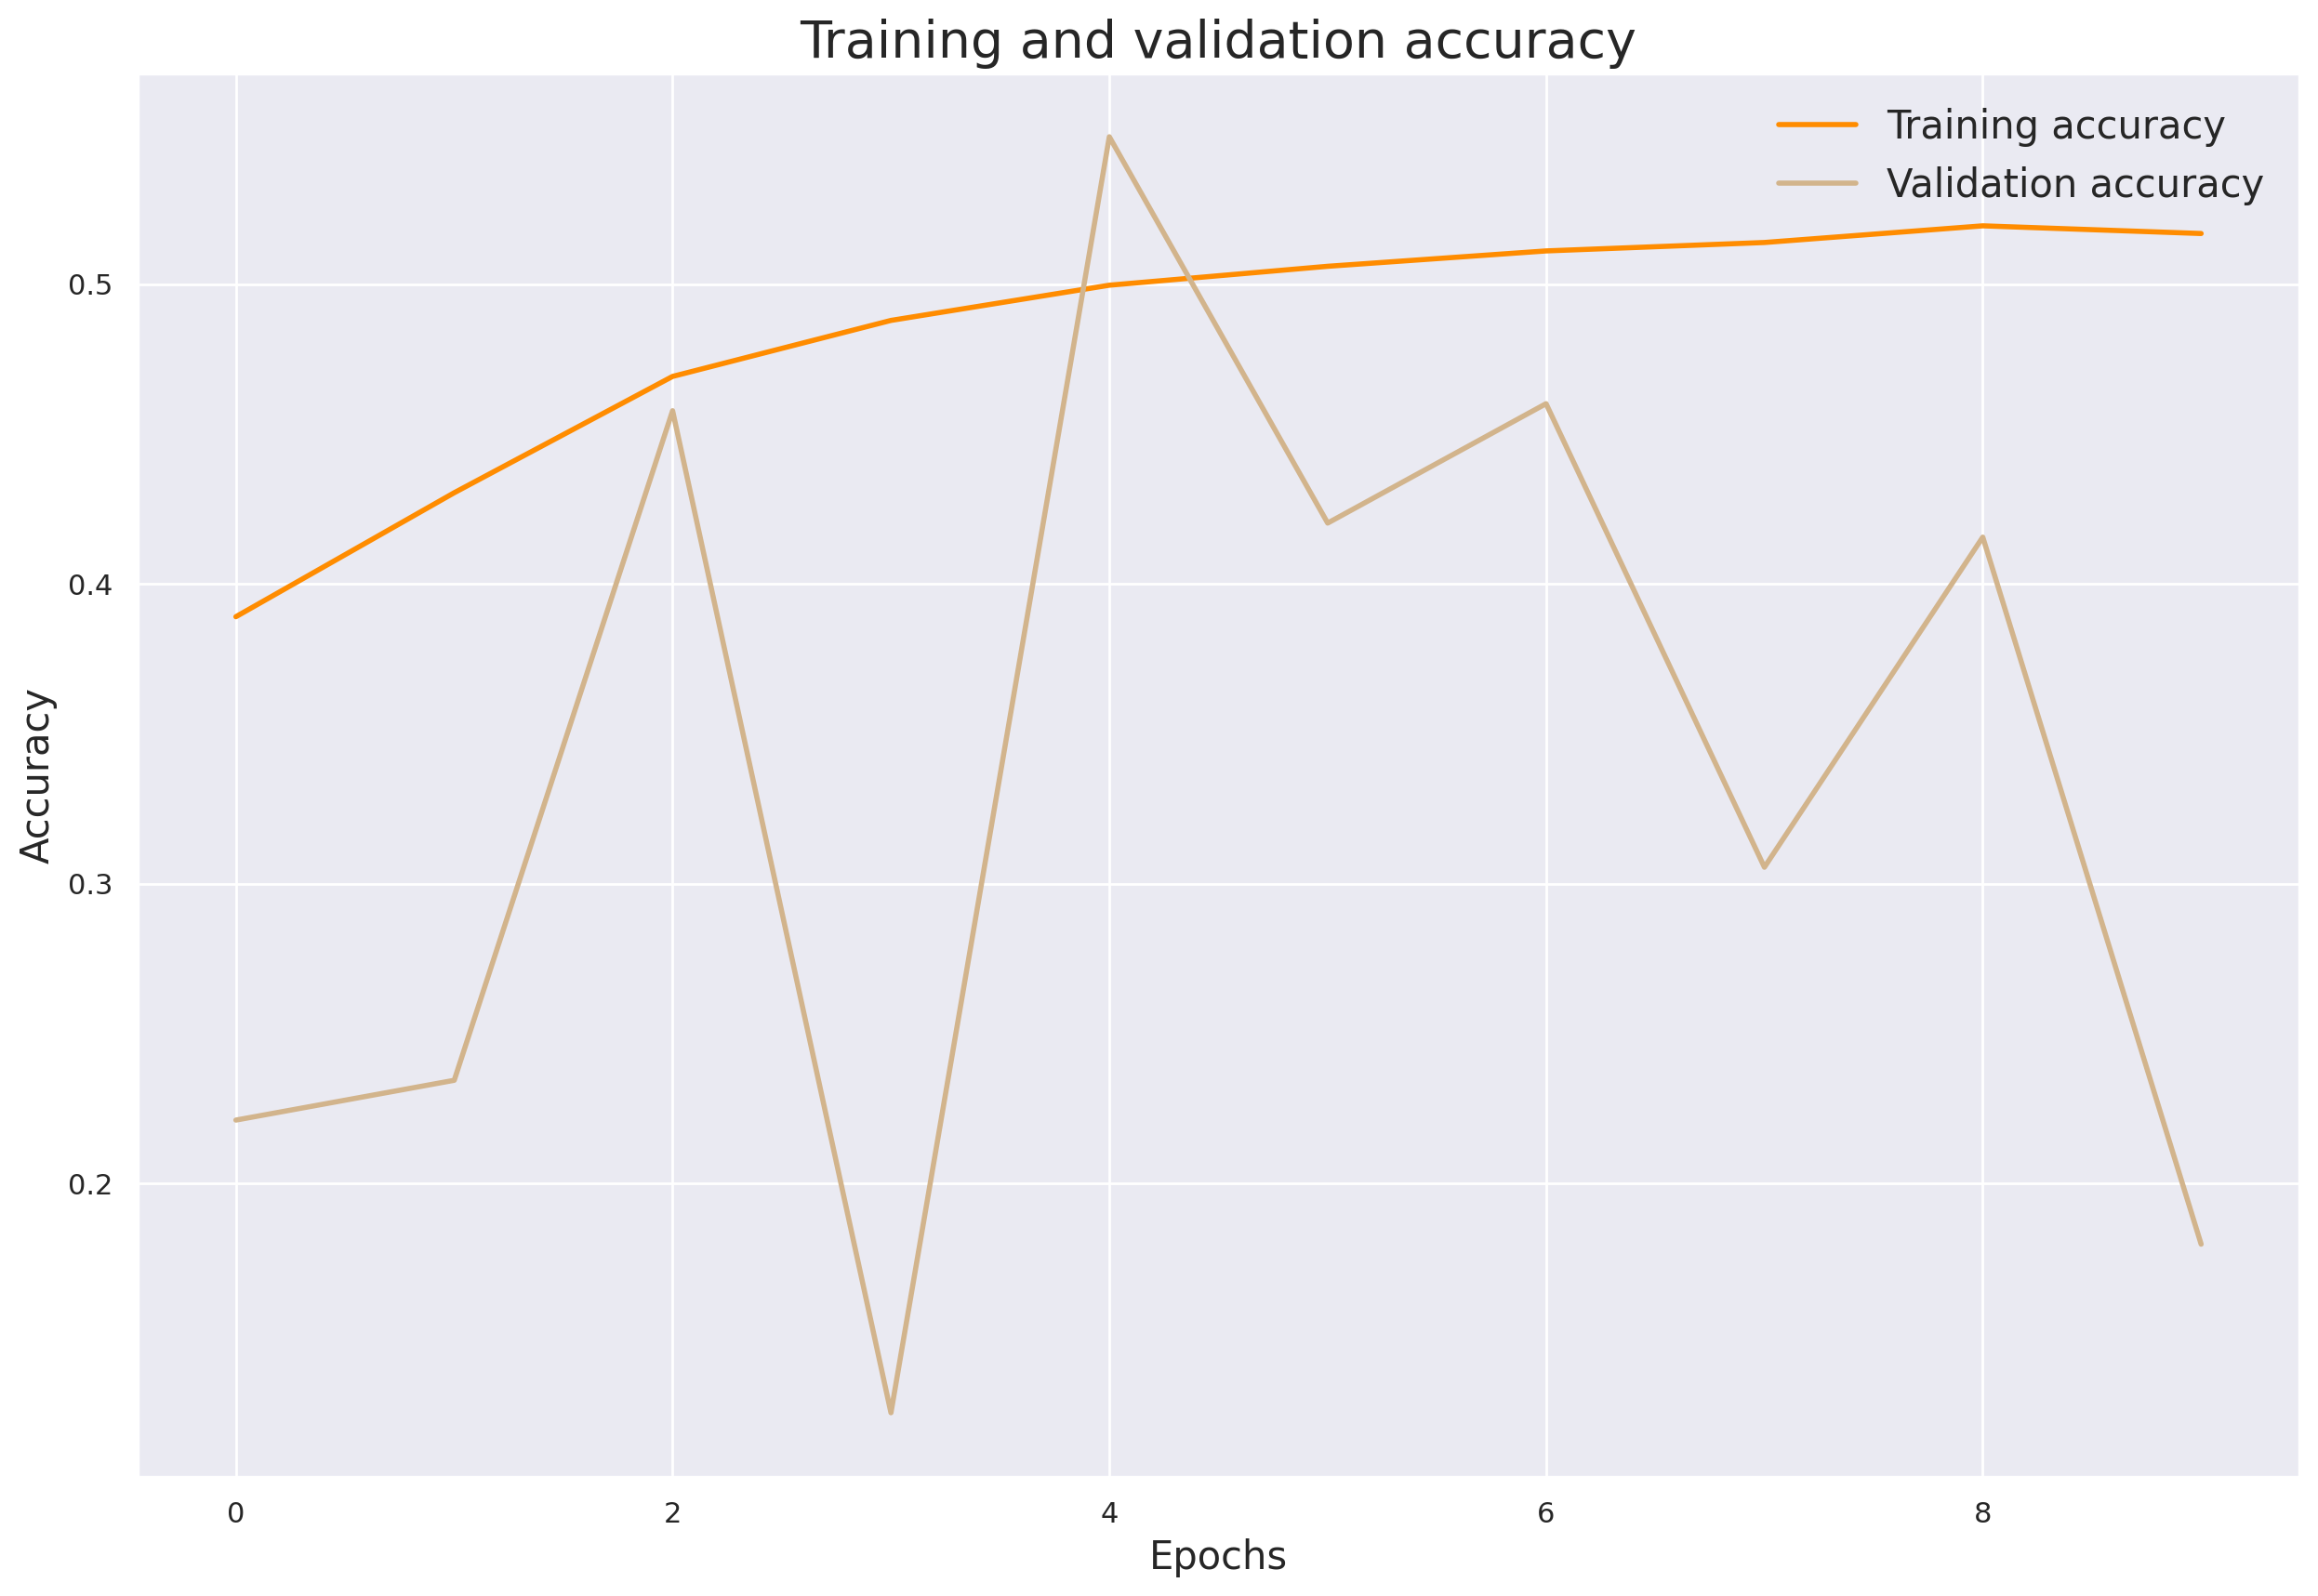

In [20]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkorange", "tan", "Accuracy")

In [21]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
)

Found 2000 images belonging to 4 classes.


In [22]:
model.evaluate(test_generator)

50/50 [==============================] - 37s 726ms/step - loss: 1.3963 - acc: 0.3825


[1.3962503671646118, 0.3824999928474426]

In [23]:
saved_model.evaluate(test_generator)

50/50 [==============================] - 34s 652ms/step - loss: 1.2529 - acc: 0.4620


[1.2528843879699707, 0.4620000123977661]

The fine-tuned ResNet model obtains a worse performance than the CNNs built from scratch. 

The accuracy and loss curves show an erratic behavior with ups and downs and clear signs of overfitting, meaning that the model might be underperforming because it is memorizing the training data instead of generalizing well to unseen data. An erratic behavior in the accuracy and loss curves can also indicate that the model is not learning a useful pattern in the data or that the training process is unstable. This can happen if the model architecture is too complex for the amount of data available, if the data is noisy or if the training hyperparameters are not well-tuned.